In [1]:
import re
import json
from collections import Counter
import matplotlib.pyplot as plt
import numpy as np
import string
from nltk.tokenize import TweetTokenizer#sentiment dict has possesive apostrophe, so we need a tokenizer that doesnt split on it
output_sentiment_length = 500

In [2]:
import sys
print (sys.version)

3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]


In [3]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\shaul\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
from gutenberg.acquire import get_metadata_cache#took about an hour to run for me
cache = get_metadata_cache()
if not cache.exists:
    cache.populate()

In [5]:
def get_text(lines):
    tokens = []
    tokenizer = TweetTokenizer()
    for line in lines:
        #tokens += tokenizer.tokenize(line)
        #tokens += nltk.word_tokenize(line)
        tokens += line.split(' ')
    tokens = [token.strip(string.punctuation) for token in tokens if len(token)>1 or str.isalpha(token)]
    text = str.join(' ', tokens)
    return text.strip()

In [6]:
def filter_gutenberg(lines):# page 16
    success = True
    start = -1
    end = -1
    for i, line in enumerate(lines):
        start_location = max(line.find('START OF THIS PROJECT GUTENBERG EBOOK'), line.find('START OF THE PROJECT GUTENBERG EBOOK'))
        if start_location != -1:
            start = i+1
    if start == -1:
        for i, line in enumerate(lines[:int(len(lines) / 2)]):
            if line.find('END')!=-1 and line.find('SMALL PRINT') != -1:
                start = i+1
        if start == -1:
            success = False
            start = 0
    for i, line in enumerate(lines):
        end_location = max(line.find('END OF THIS PROJECT GUTENBERG EBOOK'), line.find('END OF THE PROJECT GUTENBERG EBOOK'), line.lower().find('end of project gutenberg'))
        if end_location != -1:
            end = i
            break
    if end == -1:
        for i, line in enumerate(lines[3*int((len(lines)+start)/4):]):
            if line.lower().find('end') != -1 and line.lower().find('project gutenberg') != -1:
                end = 3*int((len(lines) + start)/4) + i
        if end == -1:
            for i, line in enumerate(lines[9*int((len(lines)+start)/10):]):
                end_location = line.find('THE END')
                if end_location != -1:
                    end = int(9 * (len(lines) + start)/ 10) + i
            if end==-1:
                success = False
                end = len(lines)
    return True, lines[start:end]

In [7]:
def get_sentiment_dict():
    #regex = re.compile('[^a-zA-Z0-9 ]')
    with open('D:\\labmt_dataset.json') as data:
        json_obj = json.load(data)['objects']
    sentiment_dict = {}
    for i in range(len(json_obj)):
        word = json_obj[i]['word'].lower()
        sentiment_dict[word] = json_obj[i]['happs']
    return sentiment_dict

In [8]:
def hedonometer(sentiment_dict, text, output_length, sample_length, lense = None):
    not_detected = set()
    overlap = int((len(text) - sample_length-1)/output_length)
    if overlap < 1:
        print ("Not enough words to calculate sentiment: " + str(len(text)))
        raise AssertionError("Not enough words to calculate sentiment")
    sentiments = []
    word_count = 0
    sentiment_count = 0
    for word in text[:sample_length - overlap]:
        word = word.lower()
        if word in sentiment_dict:
            if lense is None or sentiment_dict[word] <lense[0] or sentiment_dict[word]>lense[1]:
                word_count += 1
                sentiment_count += sentiment_dict[word]
    for i in range(output_length):
        for j in range(((i - 1)*overlap + sample_length),(i * overlap + sample_length)):
            word = text[j].lower()
            if word in sentiment_dict:
                if lense is None or sentiment_dict[word] <lense[0] or sentiment_dict[word]>lense[1]:
                    word_count += 1
                    sentiment_count += sentiment_dict[word]
            else:
                not_detected.add(word)
        if word_count>0:
            sentiments.append(sentiment_count/word_count)
        else:
            if len(sentiments)>0:
                sentiments.append(sentiments[-1])
            else:
                sentiments.apennd(5)
        for j in range(i*overlap, (i+1)*overlap):
            word = text[j].lower()
            if word in sentiment_dict:
                if lense is None or sentiment_dict[word] <lense[0] or sentiment_dict[word]>lense[1]:
                    word_count -= 1
                    sentiment_count -= sentiment_dict[word]
    return sentiments

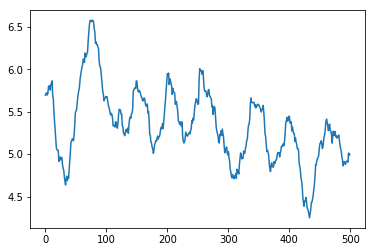

In [9]:
filename = 'D:/harrypotter.txt'
#filename = 'D:/university/NLP/ironman.txt'
with open(filename, 'r', encoding='windows-1252') as reader:
    lines = reader.readlines()

text = get_text(lines)
text = text.lower().split(' ')
sentiment_dict = get_sentiment_dict()
plt.plot(hedonometer(sentiment_dict, text, output_sentiment_length, 10000, [3,7]))
plt.show()

In [10]:
from gutenberg.query import list_supported_metadatas
from gutenberg.acquire import load_etext
from gutenberg.query import get_metadata

In [11]:
with open('D:\\university\\nlp\\bookids.txt') as id_reader:
    lines = id_reader.readlines()
    ids = [int(line) for line in lines]

In [12]:
class TextData:
    def __init__(self, name, sentiment, text):
        self.name = name
        self.sentiment = sentiment
        self.text = text

In [13]:
def get_gutenberg_text(id):
    try:
        lines = str.splitlines(load_etext(id))
    except:
        print ('text with id ' + str(id) + ' does not exist')
        return None
    success, filtered_lines = filter_gutenberg(lines)
    if not success:
        print("Failed to parse " + str(id))
    text =  get_text(filtered_lines).split(' ')
    return text

In [14]:
def get_gutenberg_texts(ids):
    sentiment_dict = get_sentiment_dict()
    textdata = {}
    disallowed_title_words = ['stories', 'collection', 'poems', 'complete', 'essays', 'fables', 'tales', 'papers', 'poetry', 'verses', 'ballads', 'sketches', 'vol.', 'vols.', 'works', 'volume', 'other']
    for id in ids:
        text = get_gutenberg_text(id)
        if text is None:
            continue
        title = 'temp'#list(get_metadata('title', id))[0]
        lowered_title = title.lower()
        valid_book = True
        for word in disallowed_title_words:
            if word in lowered_title:
                valid_book = False
                break
        if not valid_book:
            continue
        try:
            sentiment = np.array(hedonometer(sentiment_dict, text, output_sentiment_length, 10000, [3,7]))
            data = TextData(title, sentiment, text)
            textdata[id] = data
        except:
            print('failed at ' + str(id))
    return textdata
        
        

In [15]:
def plot_gutenberg_book(book_id):
    book_data = get_gutenberg_texts([book_id])[book_id]
    plt.plot(book_data.sentiment)
    plt.title(book_data.name)
    plt.show()

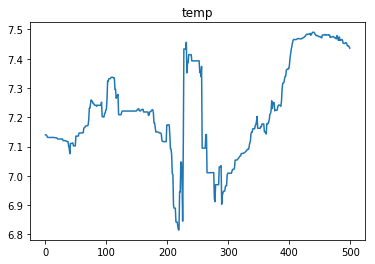

In [16]:
plot_gutenberg_book(16605)

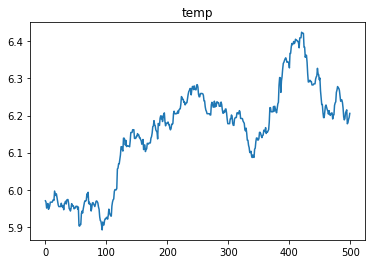

In [17]:
plot_gutenberg_book(11)

In [18]:
texts = get_gutenberg_texts(ids)

Not enough words to calculate sentiment: 9375
failed at 71
Not enough words to calculate sentiment: 8210
failed at 301
Not enough words to calculate sentiment: 8641
failed at 807
Not enough words to calculate sentiment: 7071
failed at 932
Not enough words to calculate sentiment: 7212
failed at 1034
Not enough words to calculate sentiment: 8975
failed at 1238
Not enough words to calculate sentiment: 9216
failed at 1642
Not enough words to calculate sentiment: 9454
failed at 2003
Not enough words to calculate sentiment: 8667
failed at 2344
Not enough words to calculate sentiment: 7315
failed at 2345
Not enough words to calculate sentiment: 7702
failed at 2348
Not enough words to calculate sentiment: 10005
failed at 2349
Not enough words to calculate sentiment: 9889
failed at 2373
Not enough words to calculate sentiment: 7258
failed at 3250
Not enough words to calculate sentiment: 7583
failed at 4507
text with id 5001 does not exist
Not enough words to calculate sentiment: 7075
failed at 

In [19]:
print(len(texts))

1641


In [20]:
import numpy as np
def svd_analysis(texts):
    input_matrix = np.array(texts)
    return np.linalg.svd(input_matrix, full_matrices = False)

In [21]:
order_mapping = dict(zip(texts.keys(), list(range(len(texts)))))
reverse_order_mapping = dict(zip(list(range(len(texts))), texts.keys()))
data = np.array([text.sentiment-np.mean(text.sentiment) for text in texts.values()])

In [22]:
u, sigma, v = svd_analysis(data)
w= u * sigma # mode coefficients

In [23]:
def plot_svd_basis(v):
    fig, axes = plt.subplots(4, 3)
    for i in range(4):
        for j in range(3):
            index = 3*i+j
            axes[i, j].plot(v[index])
            axes[i,j].title.set_text('Mode ' + str(index+1))
    plt.tight_layout()
    plt.show()

In [ ]:
plot_svd_basis(v)

In [ ]:
np.sum(sigma[:12]**2)/np.sum(sigma**2)#explained variance

In [ ]:
def nearest_neighbors(value, array, nbr_neighbors=1):#https://stackoverflow.com/questions/45742199/find-nearest-neighbors-of-a-numpy-array-in-list-of-numpy-arrays-using-euclidian
    return np.argsort(np.array([np.sum(np.abs(value-x)) for x in array]))[:nbr_neighbors]

In [ ]:
def plot_svd_modes(data, v, w):
    fig, axes = plt.subplots(2, 3)
    fig.set_size_inches(20,10)
    for i in range(3):
        neighbors = np.argsort(w[:,i])[-20:]
        for neighbor in neighbors:
            axes[0, i].plot(data[neighbor]/w[neighbor, i], 'gray')
        axes[0, i].plot(v[i], 'orange')
        neighbors = np.argsort(w[:,i])[:20]
        for neighbor in neighbors:
            axes[1, i].plot(data[neighbor]/-w[neighbor, i], 'gray')
        axes[1, i].plot(-v[i], 'orange')

In [ ]:
plot_svd_modes(data, v, w)

In [ ]:
from sklearn.cluster import AgglomerativeClustering
def cluster(data, number_of_clusters):
    cluster = AgglomerativeClustering(n_clusters=number_of_clusters, linkage='ward')
    prediction = cluster.fit_predict(data)
    return prediction

In [ ]:
def show_heirarchical_clustering(data, number_of_clusters, prediction):
    cluster_means = []
    fig, axes = plt.subplots(int((number_of_clusters-1)/3)+1, 3)
    fig.set_size_inches(20,10)
    for i in range(int((number_of_clusters-1)/3)+1):
        for j in range(3):
            if 3*i + j >= number_of_clusters:
                continue
            relevant_sentiments = np.where(prediction== 3*i + j)
            total = np.zeros(output_sentiment_length)
            for index in relevant_sentiments[0]:
                total += data[index]
            mean = total/len(relevant_sentiments[0])
            neighbors = nearest_neighbors(mean, data[relevant_sentiments[0]], 20)
            for neighbor in neighbors:
                if len(axes.shape)>1:
                    axes[i, j].plot(data[relevant_sentiments[0]][neighbor], 'gray')
                else:
                    axes[j].plot(data[relevant_sentiments[0]][neighbor], 'gray')
            if len(axes.shape)>1:
                axes[i, j].plot(mean, 'orange')
                axes[i, j].title.set_text(str(len(relevant_sentiments[0])))
            else:
                axes[j].plot(mean, 'orange')
                axes[j].title.set_text(str(len(relevant_sentiments[0])))
            cluster_means.append(mean)
    return cluster_means
    

In [ ]:
number_of_clusters = 9
predictions = cluster(data, number_of_clusters)
cluster_means = show_heirarchical_clustering(data, number_of_clusters, predictions)

In [ ]:
from scipy.cluster.hierarchy import dendrogram,linkage
fig = plt.figure(figsize=(25, 10))
fit = linkage(data,metric='euclidean',method='ward')
dn = dendrogram(fit)
plt.show()

In [ ]:
def get_cluster_svd_correlation(w, predictions):
    modes = []
    for i in range(w.shape[0]):
        svd_mode = np.argmax(np.abs(w[i, :]))
        if np.sign(w[i, svd_mode]) < 0:
            modes.append(-svd_mode - 1)
        else:
            modes.append(svd_mode)
    color_map = np.zeros((6, number_of_clusters))
    for i in range(len(predictions)):
        if -3<=modes[i]<3:
            color_map[modes[i]+3, predictions[i]] += 1
    for i in range(color_map.shape[1]):
        color_map[:, i]/=np.sum(color_map[ :, i])
    print(color_map)
    plt.matshow(color_map, cmap=plt.get_cmap('Blues'))
    plt.show()
    return modes

In [ ]:
modes = get_cluster_svd_correlation(w, predictions)

In [ ]:
#https://rubikscode.net/2018/08/27/implementing-self-organizing-maps-with-python-and-tensorflow/
from minisom import MiniSom
map_size = 8
som = MiniSom(map_size, map_size, 500)
som.train_random(data, 5000)
label_map = som.labels_map(data, modes)

In [ ]:
plt.bone()
plt.matshow(som.distance_map())
plt.colorbar()
plt.show()

In [ ]:
def plot_clustering_som_correlation(map_size, label_map):
    fig, axes = plt.subplots(2, 3)
    for sub_plot in range(3):
        color_map = np.zeros((map_size, map_size))
        for i in range(color_map.shape[0]):
            for j in range(color_map.shape[1]):
                color_map[i][j] = label_map[(i, j)][sub_plot]
                axes[0, sub_plot].imshow(color_map, cmap=plt.get_cmap('Blues'))
        color_map = np.zeros((map_size, map_size))
        for i in range(color_map.shape[0]):
            for j in range(color_map.shape[1]):
                color_map[i][j] = label_map[(i, j)][-sub_plot-1]
                axes[1, sub_plot].imshow(color_map, cmap=plt.get_cmap('Blues'))
    plt.show()

In [ ]:
plot_clustering_som_correlation(map_size, label_map)

In [ ]:
help(MiniSom)

In [ ]:
import csv
import sys
movie_scripts = {}
sentiment_dict = get_sentiment_dict()
csv.field_size_limit(100000000)
with open(r'D:\university\NLP\movies-and-movie-scripts\moviedataset.csv', encoding='utf8') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    row_count = 0
    for row in csv_reader:
        if row_count > 0:
            lines = str.splitlines(row[-1])
            text= get_text(lines).split(' ')
            try:
                movie_scripts[int(row[0])] = TextData(row[3], hedonometer(sentiment_dict, text, output_sentiment_length, 1150, [3,7]), text)
            except:
                print('failed at ' + row[0])
        else:
            None
        row_count += 1
            
        

In [ ]:
print(np.mean([len(book.text) for book in texts.values()]))
print(np.mean([len(movie.text) for movie in movie_scripts.values()]))

In [ ]:
len(movie_scripts)

In [ ]:
movie_index = 757
plt.plot(movie_scripts[movie_index].sentiment)
plt.title(movie_scripts[movie_index].name)
plt.show()

In [ ]:
[(id,movie_scripts[id].name) for id in movie_scripts]

In [ ]:
order_mapping2 = dict(zip(movie_scripts.keys(), list(range(len(movie_scripts)))))
reverse_order_mapping2 = dict(zip(list(range(len(movie_scripts))), movie_scripts.keys()))
data2 = np.array([movie.sentiment-np.mean(movie.sentiment) for movie in movie_scripts.values()])

In [ ]:
u2, sigma2, v2 = svd_analysis(data2)
w2= u2 * sigma2 # mode coefficients

In [ ]:
plot_svd_basis(v2)

In [ ]:
np.sum(sigma2[:12]**2)/np.sum(sigma2**2)#explained variance

In [ ]:
plot_svd_modes(data2, v2, w2)

In [ ]:
number_of_clusters = 9
movie_predictions = cluster(data2, number_of_clusters)
cluster_means_movies = show_heirarchical_clustering(data2, number_of_clusters, movie_predictions)

In [ ]:
modes_movies = get_cluster_svd_correlation(w2, movie_predictions)

In [ ]:
#https://rubikscode.net/2018/08/27/implementing-self-organizing-maps-with-python-and-tensorflow/
from minisom import MiniSom
map_size = 8
som = MiniSom(map_size, map_size, 500)
som.train_random(data2, 5000)
label_map_movies = som.labels_map(data2, modes_movies)

In [ ]:
plot_clustering_som_correlation(map_size, label_map_movies)